In [1]:
import time
import os
import cv2

from lib.file.TIF import *
from lib.analysis.ROI_identification import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.file.TSV import RegionExporter
from lib.analysis.align import ImageAlign
from lib.file.DAT import TracesDAT
from lib.trace import Tracer
from lib.utilities import *
from lib.analysis.laminar_dist import *

7
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/ ['02-02-23', 'converted_zda'] []
7
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/02-02-23
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/02-02-23 [] ['1-1.tif', '1-1e.tif', '1-1f.tif']
7
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda [] ['01_01_01.zda', '01_01_02.zda', '01_01_03.zda', '01_01_04.zda', '01_01_05.zda', '01_01_06.zda', '01_01_07.zda', '01_01_08.zda', '01_01_09.zda', '01_01_10.zda', '01_01_11.zda', '01_01_12.zda', '01_01_13.zda', '01_01_14.zda', '01_01_15.zda', '01_01_16.zda', '01_01_17.zda', '01_01_18.zda', '01_01_19.zda', '01_01_20.zda', '01_01_21.zda', '01_01_22.zda', '01_01_23.zda', '02-02-23_snr.dat', 'corners_barrel.dat', 'corners_layer.dat', 'electrode.dat']
slice 2 , rec 23
C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda/corners_layer.dat
edge_pts [[17, 79], [48, 79]] axis_pts [[49, 13], [

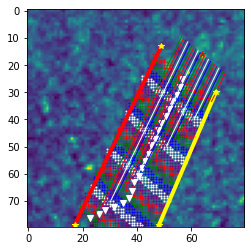

C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda/corners_barrel.dat
edge_pts [[14, 0], [35, 0]] axis_pts [[49, 21], [60, 7]]
laminar axis unit vectors: [-0.8574929257125442, -0.5144957554275266] [-0.9629640197141817, -0.2696299255199709]
ROI centers: [[50.59, 12.09], [47.39, 11.49], [44.56, 10.5], [42.21, 8.77], [39.2, 7.89], [36.3, 6.85], [33.54, 5.79], [31.11, 4.27], [27.79, 3.73], [24.41, 2.83]]
Created file: C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda/rois_01_to_13.dat
Stim point: [64, 16]
laminar_distances: [13.51, 16.57, 19.5, 22.41, 25.44, 28.46, 31.37, 34.24, 37.37, 40.72]
laminar_distances 2: [13.97, 17.21, 20.2, 22.93, 26.07, 29.14, 32.08, 34.84, 38.18, 41.67]
laminar_distances averaged : [13.74, 16.89, 19.85, 22.67, 25.76, 28.8, 31.72, 34.54, 37.78, 41.2]
File created:  C:/Users/jjudge3/Desktop/Data/Kate's/02-02-23/converted_zda/corners_barrel_laminar_distances.txt


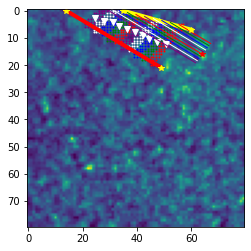





	tolerance exception count: 0
	slice directory count: 2
	Number of measurements made: 2


In [14]:
# parameter values work for any Google Drive for desktop
data_dir = "G:/.shortcut-targets-by-id/"
data_dir = "C:/Users/jjudge3/Desktop/Data/Kate's/02-10-23/"
target_depth = subdir.count('/') + subdir.count('\\') + 2
date_folder_filter = None  # 'nbqx'

# sets of files in each slice directory -- naming convention
# input
corners_file_prefix_layer = 'corners_layer'
corners_file_prefix_barrel = 'corners_barrel'
electrode_file_prefix = 'electrode'
# also needed: 01_01_01_snr.dat

# output files
rois_file_prefix = 'rois' # e.g. 'rois_01_to_09.dat'

image_data = {}
n_plots = 5000  # show up to how many plots
ld_tolerance = 0.05  # laminar distance tolerance between axes (fractional)
tol_exception_count = 0
slice_count = 0
meas_count = 0

for subdir, dirs, files in os.walk(data_dir):
    
    depth = subdir.count('/') + subdir.count('\\')
    if depth > target_depth:  # don't care about any deeper dir
        continue
    if 'notUsable' in subdir:
        continue
    #if date_folder_filter is not None and date_folder_filter not in subdir:
    #    continue
    if depth < target_depth:
        print(subdir, dirs, files)
    subdir += '/'
    if len(files) > 0:
        slice_count += 1
    for filename in files:
        if filename.split(".")[0].endswith("_snr"):
            name_parse = filename[:8]  # of the format 07_01_01
            try:
                slic, loc, rec = [int(x) for x in name_parse.split('-')]
            except ValueError:
                continue
            if slic not in image_data:
                image_data[slic] = {}
            if loc not in image_data[slic]:
                image_data[slic][loc] = {}
            snr = np.loadtxt(subdir + filename,
                             delimiter='\t',
                             usecols=(1,))
            width = int(np.sqrt(snr.shape[0]))
            snr = snr.reshape((width, width))

            print("slice", slic, ", rec", rec)

            # open corners, interlaminar, 2 points p1, p2 to define the edge along which to measure
            
            for la_file in [subdir + corners_file_prefix_layer + '.dat', 
                            subdir + corners_file_prefix_barrel + '.dat']:
                lines = None
                print(la_file)
                if os.path.exists(la_file):
                    meas_count += 1
                    with open(la_file, 'r') as f:
                        lines = f.readlines() 
                    corners = [int(x) for x in lines[4:]] # the last 4 lines are diode numbers of corners
                    layer_axes = LayerAxes(corners)
                    laminar_axis, laminar_axis_2 = layer_axes.get_layer_axes()
                    print("laminar axis unit vectors:", laminar_axis.get_unit_vector(), 
                          laminar_axis_2.get_unit_vector())

                    # make our own ROIs from the list of edges and write them to a .dat file
                    roi_cr = ROICreator(layer_axes)
                    rois = roi_cr.get_rois()  # list of LaminarROI objects
                    roi_centers = [r.get_center() for r in rois]
                    roi_centers = [[round(r[0], 2), round(r[1], 2)] for r in roi_centers]
                    print("ROI centers:", roi_centers)
                    
                    # write these ROIs to file
                    roi_cr.write_roi_file(subdir, rois_file_prefix)

                    # open stim point roi as a single integer (its diode number) in variable stim_pt
                    sp_file = subdir + electrode_file_prefix + '.dat'
                    with open(sp_file, 'r') as f:
                        lines = f.readlines()
                    stim_pt = int(lines[-1]) # last line is always electrode location
                    aux_obj = LaminarROI([stim_pt]).get_points()
                    stim_pt = aux_obj[0]  # should be a list of len 2, representing px location [x, y]
                    print("Stim point:", stim_pt)

                    # run laminar dist computation
                    laminar_distances_obj = LaminarDistance(laminar_axis, rois, stim_pt)
                    laminar_distances = laminar_distances_obj.compute_laminar_distances()
                    laminar_distances = [round(ld, 2) for ld in laminar_distances]
                    print('laminar_distances:', laminar_distances)  # a list of integers with same indexing as rois

                    # run laminar dist again with the other axis
                    laminar_distances_2 = LaminarDistance(laminar_axis_2, rois, stim_pt).compute_laminar_distances()
                    laminar_distances_2 = [round(ld, 2) for ld in laminar_distances_2]
                    print('laminar_distances 2:', laminar_distances_2)  # a list of integers with same indexing as rois
                    
                    diff_lds_exceeds_tol = [np.abs(laminar_distances[i] - laminar_distances_2[i])
                                            / laminar_distances[i] > ld_tolerance
                               for i in range(len(laminar_distances))]
                    if any(diff_lds_exceeds_tol):
                        print("\n\n\n ********  CHECK LAMINAR DISTANCE MEASUREMENTS ******** \n\n\n")
                        print("\t difference exceeds tolerance of", ld_tolerance * 100, "%")
                        tol_exception_count += 1
                    
                    # write averaged laminar distances to file
                    avg_laminar_distances = [round(
                        (laminar_distances[i] + laminar_distances_2[i]) / 2,
                        2)
                                            for i in range(len(laminar_distances))]
                    print('laminar_distances averaged :', avg_laminar_distances) 
                    ld_filename_base = la_file[:-4] + "_"
                    laminar_distances_obj.write_laminar_distance_file(ld_filename_base, avg_laminar_distances)

                    image_data[slic][loc][rec] = {
                        'snr': snr,
                        'filename': filename,
                        'laminar_distances': laminar_distances}

                    # Now that the data is stored, show intermediate computations in plot
                    if n_plots > 0:
                        lines = [laminar_axis.get_line_repr(),
                                 laminar_axis_2.get_line_repr()]
                        line_colors = ['red', 'yellow']
                        linewidths = [4,4]
                        other_colors = ['red', 'green', 'blue', 'white', 'purple']
                        roi_colors = []

                        # laminar aux lines
                        uv = laminar_axis.get_unit_vector()
                        for i in range(len(laminar_distances)):
                            ld = laminar_distances[i]
                            jiggle = i - int(len(laminar_distances) / 2)
                            uv_perp = Line(laminar_axis.get_start_point(), 
                                           laminar_axis_2.get_start_point()).get_unit_vector()
                            stim_proxy_pt = [stim_pt[0] - jiggle * uv_perp[0], 
                                             stim_pt[1] - jiggle * uv_perp[1]]
                            measure_vector = [uv[0] * ld + stim_proxy_pt[0], uv[1] * ld + stim_proxy_pt[1]]
                            lines.append([measure_vector, stim_proxy_pt])
                            this_color = other_colors[i % len(other_colors)]
                            line_colors.append(this_color)
                            roi_colors.append(this_color)
                            linewidths.append(1)

                        LaminarVisualization(snr, 
                                             stim_pt, 
                                             roi_centers, 
                                             layer_axes.get_corners(),
                                             lines,
                                             line_colors,
                                             linewidths,
                                             rois,
                                             roi_colors,
                                             save_dir=subdir+"LaminarVisual"+name_parse+'.png')
                        n_plots -= 1

print("\n\n\n\n\ttolerance exception count:", tol_exception_count)
print("\tslice directory count:", slice_count)
print("\tNumber of measurements made:", meas_count)